In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import ewt_transform as ewt 

import os 
from tqdm import tqdm 

import tensorflow as tf
from tensorflow.keras import models, layers

from sklearn.metrics import mean_squared_error as mse 
from sklearn.preprocessing import MinMaxScaler

path_to_csv = 'C:/Users/bachu/Documents/Python Scripts/DSP Miniproject/Datasets/GS.csv'

In [2]:
data = pd.read_csv(path_to_csv)
closing_prices = list(data['Close'].interpolate())
dates = list(data['Date'])

In [3]:
split_size = 0.7
window_size = 30
learning_rate = 0.01
batch_size = 32
buffer = 100
epochs = 200
split_point = int(split_size*len(data))

# sc = MinMaxScaler(feature_range = (-1, 1))

In [4]:
def get_windowed_dataset(data, window_size, split_point, scaler):
    
    train_data = scaler.fit_transform(data.values)
    val_data = scaler.fit_transform(data.values)

    X_train = []
    Y_train = []


    for i in range(window_size, split_point):
        X_train.append(train_data[i-window_size : i, 0])
        Y_train.append(train_data[i, 0])
        
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    return X_train, Y_train, scaler

In [5]:
def get_model(window_size = window_size):

    model = models.Sequential()
    
    model.add(layers.LSTM(units = window_size, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.LSTM(units = window_size))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(units = 128))
    model.add(layers.Dense(units = 1))

    model.summary()
    return model

In [6]:
def plot_metrics(history, epochs, title):

    mse, mae, huber = history["loss"], history["mae"], history["huber_loss"]
    epochs_axis = np.arange(1, epochs + 1)

    plt.style.use('dark_background')
    fig, ax = plt.subplots(1, 3, figsize = (20, 5), constrained_layout = True)

    ax[0].plot(epochs_axis, huber)
    ax[0].set_title('Huber Loss', fontsize = 20)
    ax[0].set_xlabel('Epochs', fontsize = 15)
    ax[0].set_ylabel('Huber Loss', fontsize = 15)
    ax[0].tick_params(axis="both", labelsize=15)

    ax[1].plot(epochs_axis, mae)
    ax[1].set_title('MAE', fontsize = 20)
    ax[1].set_xlabel('Epochs', fontsize = 15)
    ax[1].set_ylabel('MAE', fontsize = 15)
    ax[1].tick_params(axis="both", labelsize=15)

    ax[2].plot(epochs_axis, mse)
    ax[2].set_title('MSE Loss', fontsize = 20)
    ax[2].set_xlabel('Epochs', fontsize = 15)
    ax[2].set_ylabel('MSE Loss', fontsize = 15)
    ax[2].tick_params(axis="both", labelsize=15)

    plt.suptitle(title, fontsize = 15)

In [7]:
def model_forecast(data, model, window_size, split_point, scaler):
#   data = data.iloc[:, 4:5]
  data = data[split_point - window_size:].values

  data = data.reshape(-1, 1)
  data = scaler.transform(data)

  X_test = []
  for i in range(window_size, len(data)):
    X_test.append(data[i-window_size : i, 0])

  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  preds = scaler.inverse_transform(model.predict(X_test))
  return preds
    

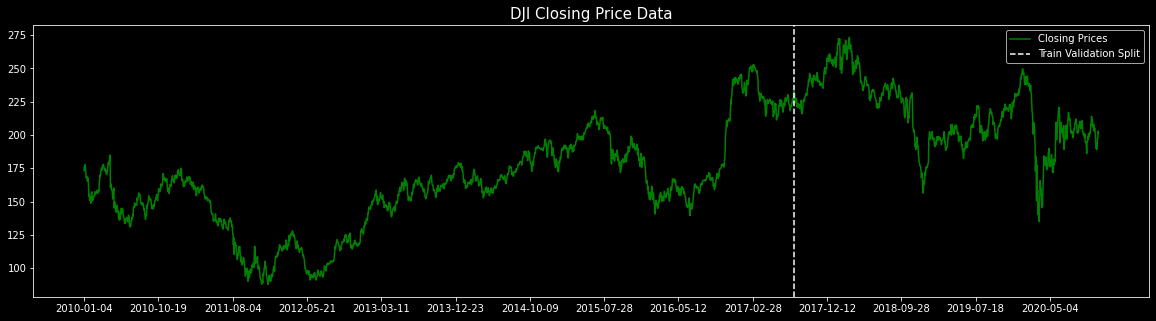

In [8]:
plt.style.use('dark_background')
plt.figure(figsize = (20, 5))
date_ticks = []
x_ticks_pos = []
for i, j in enumerate(dates):
  if not i%200:
    date_ticks.append(j)
    x_ticks_pos.append(i)

plt.plot(closing_prices, color = 'g')
plt.axvline(split_point, color = 'w', linestyle = '--')
plt.xticks(x_ticks_pos, date_ticks)
plt.title('DJI Closing Price Data', fontsize = 15)
plt.legend(['Closing Prices', 'Train Validation Split'])
plt.show()

In [9]:
N = 10
data = ewt.EWT1D(np.array(closing_prices), N = N)[0]
data = data.T

Text(0.5, 0.98, 'Frequency Decomposition')

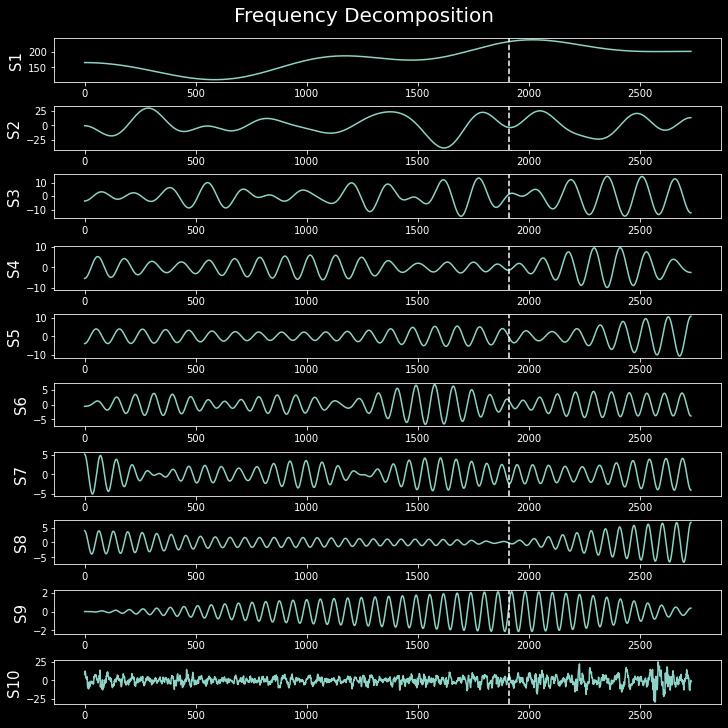

In [10]:
fig, ax = plt.subplots(10, 1, constrained_layout = True, figsize = (10, 10))
for i in range(10):
    ax[i].plot(data[i])
    ax[i].axvline(split_point, color = 'w', linestyle = '--')
    ax[i].set_ylabel('S{}'.format(i+1), fontsize = 15)
fig.suptitle('Frequency Decomposition', fontsize = 20)

In [11]:
# data = sc2.fit_transform(data)
decomposed = pd.DataFrame(data = data.T)
decomposed.head()

,0,1,2,3,4,5,6,7,8,9
0,164.939584,-1.050687,-3.669957,-5.339748,-4.011704,-0.595169,5.170905,3.917869,0.004203,7.845209
1,164.938923,-1.056263,-3.664062,-5.324896,-3.997262,-0.594562,5.131210,3.881173,0.004365,10.947692
2,164.937600,-1.067411,-3.652282,-5.295235,-3.968430,-0.593337,5.052130,3.808125,0.004687,9.149202
3,164.935617,-1.084126,-3.634638,-5.250850,-3.925311,-0.591469,4.934278,3.699412,0.005159,12.684790
4,164.932973,-1.106396,-3.611161,-5.191865,-3.868061,-0.588923,4.778573,3.556054,0.005772,9.484094


In [12]:
models_list = []
models_hists = []
scalers = []
for i in range(N):
    scaler = MinMaxScaler(feature_range = (0, 1))
    X_train, Y_train, scaler = get_windowed_dataset(decomposed.iloc[:, i:i+1], window_size, split_point, scaler)
    model = get_model()
    model.compile(optimizer = tf.keras.optimizers.Adam(), 
    loss = 'mean_squared_error', metrics = ['mae', tf.keras.losses.Huber()])
    model_hist = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch_size)
    models_list.append(model)
    models_hists.append(model_hist)
    scalers.append(scaler)


s/sample - loss: 0.0022 - mae: 0.0353 - huber_loss: 0.0011
Epoch 43/200
1882/1882 [==============================] - 1s 277us/sample - loss: 0.0022 - mae: 0.0353 - huber_loss: 0.0011
Epoch 44/200
1882/1882 [==============================] - 1s 269us/sample - loss: 0.0021 - mae: 0.0351 - huber_loss: 0.0011
Epoch 45/200
1882/1882 [==============================] - 1s 325us/sample - loss: 0.0021 - mae: 0.0347 - huber_loss: 0.0010
Epoch 46/200
1882/1882 [==============================] - 1s 329us/sample - loss: 0.0022 - mae: 0.0358 - huber_loss: 0.0011
Epoch 47/200
1882/1882 [==============================] - 1s 361us/sample - loss: 0.0022 - mae: 0.0355 - huber_loss: 0.0011
Epoch 48/200
1882/1882 [==============================] - 1s 326us/sample - loss: 0.0021 - mae: 0.0351 - huber_loss: 0.0011
Epoch 49/200
1882/1882 [==============================] - 1s 294us/sample - loss: 0.0022 - mae: 0.0356 - huber_loss: 0.0011
Epoch 50/200
1882/1882 [==============================] - 1s 316us/sample

10it [00:00, 17.13it/s]


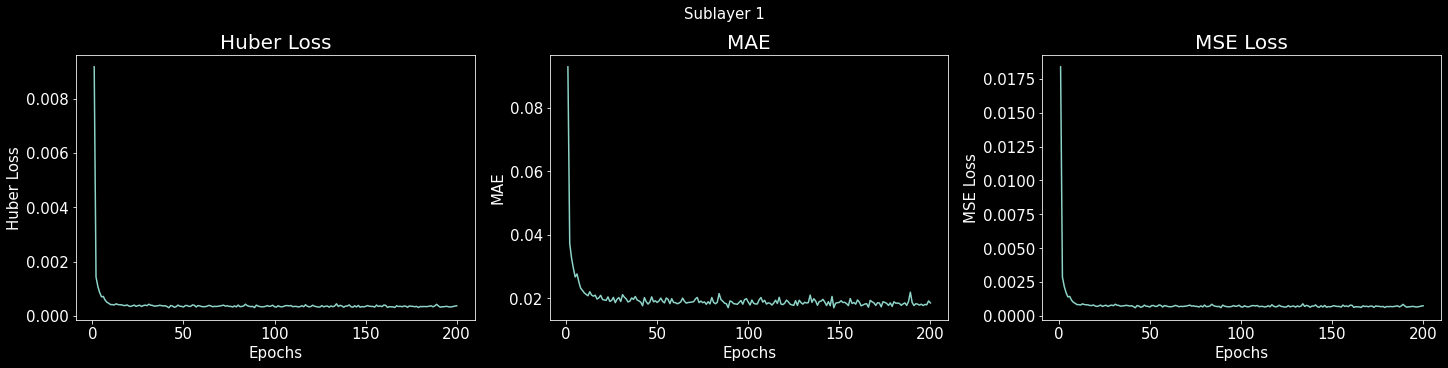

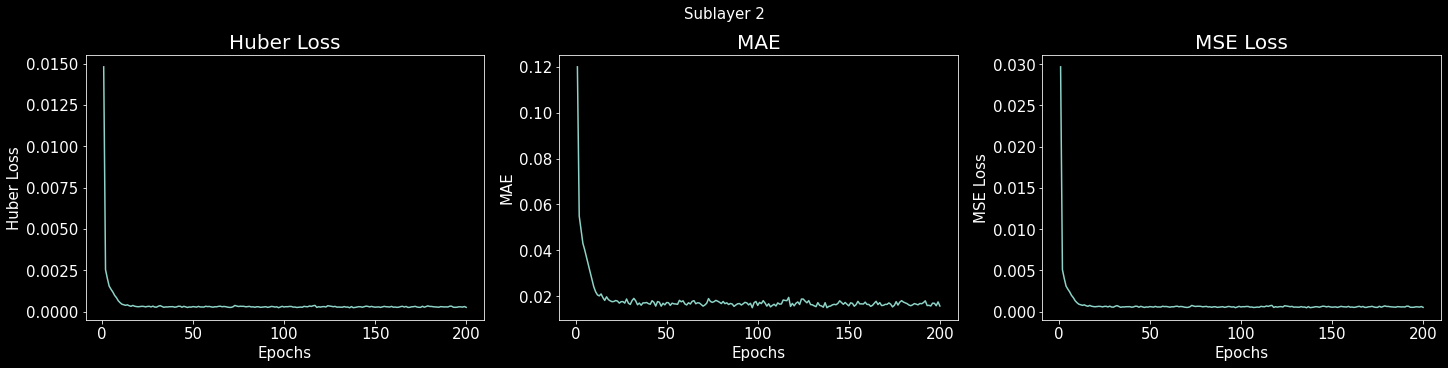

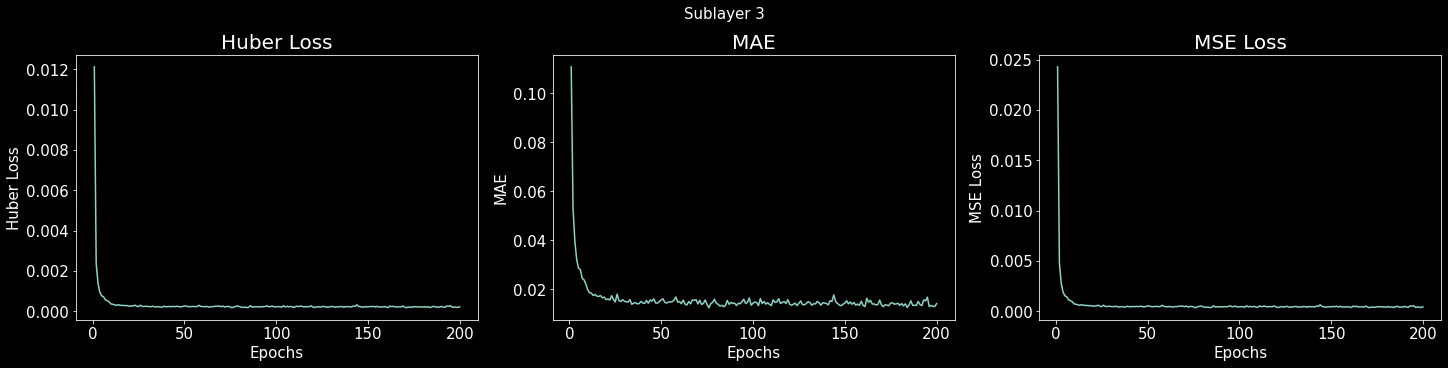

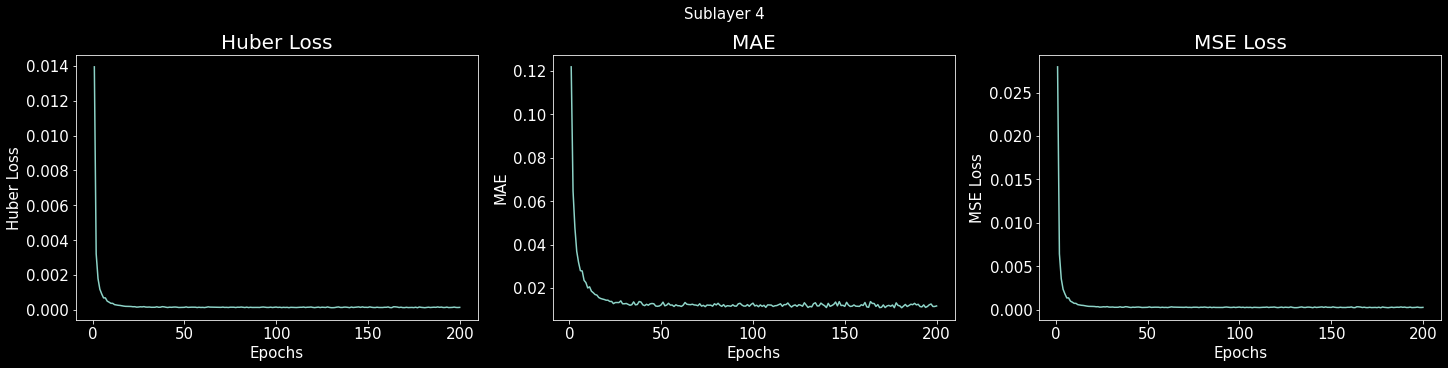

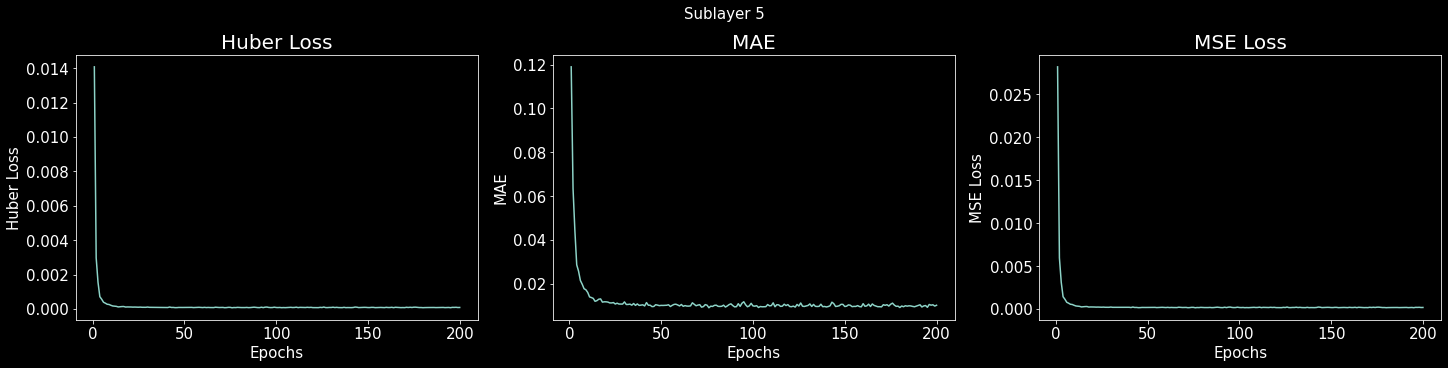

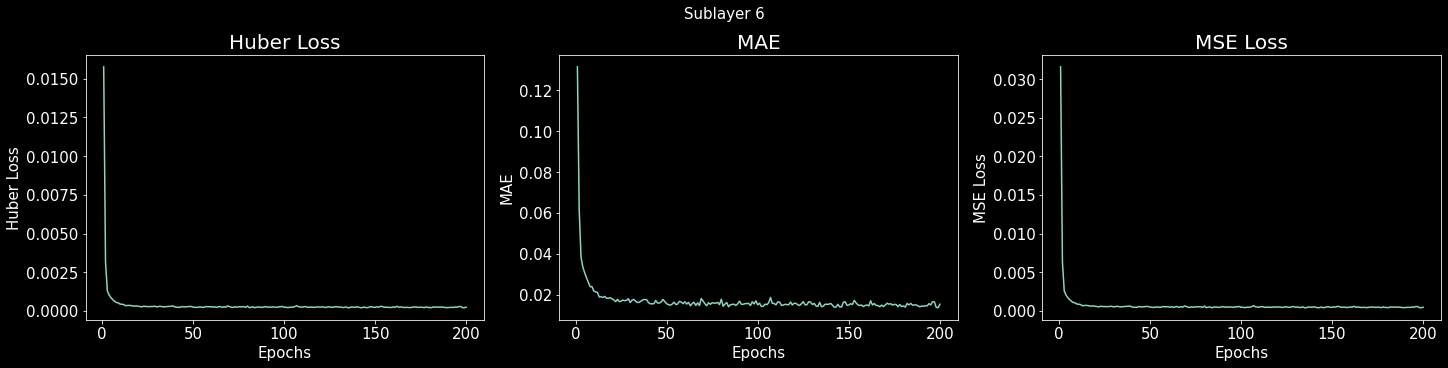

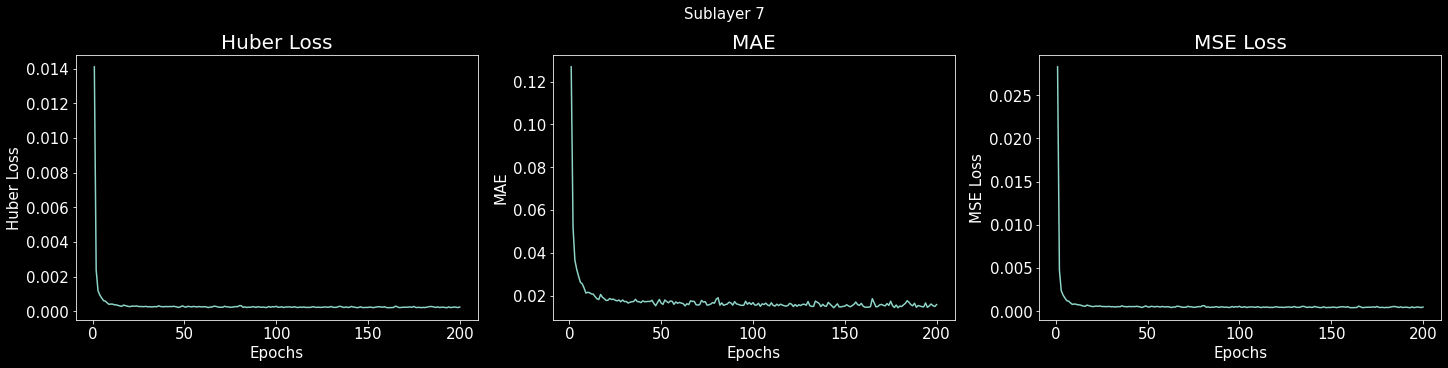

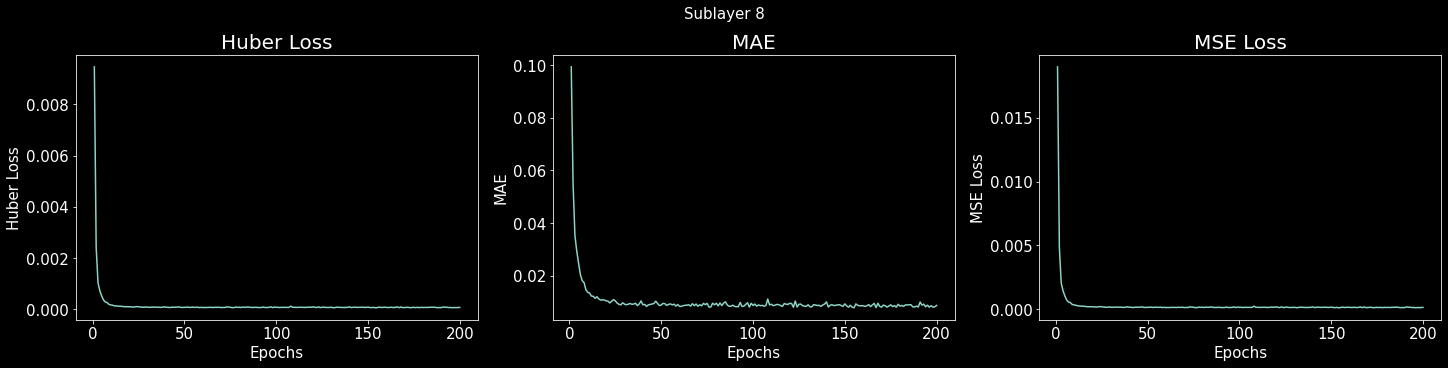

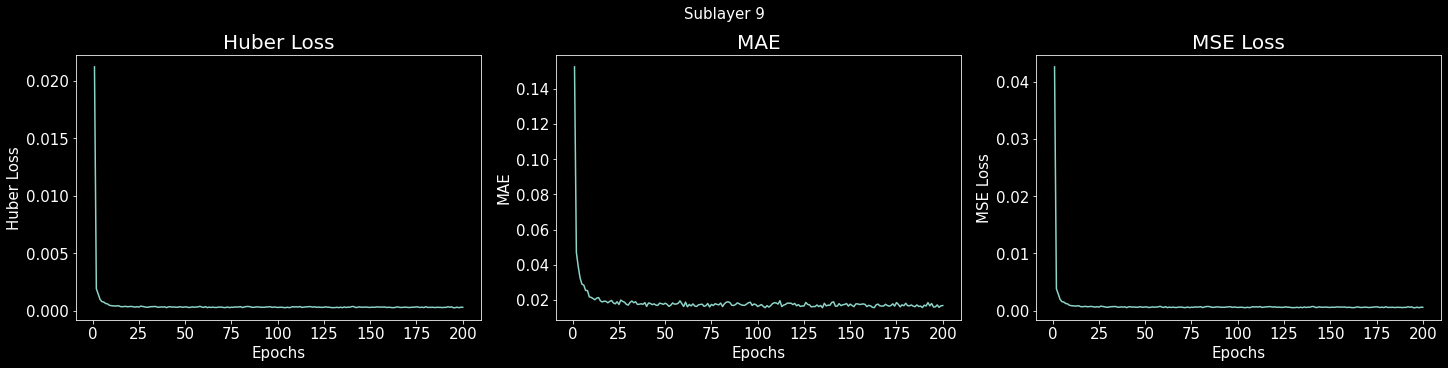

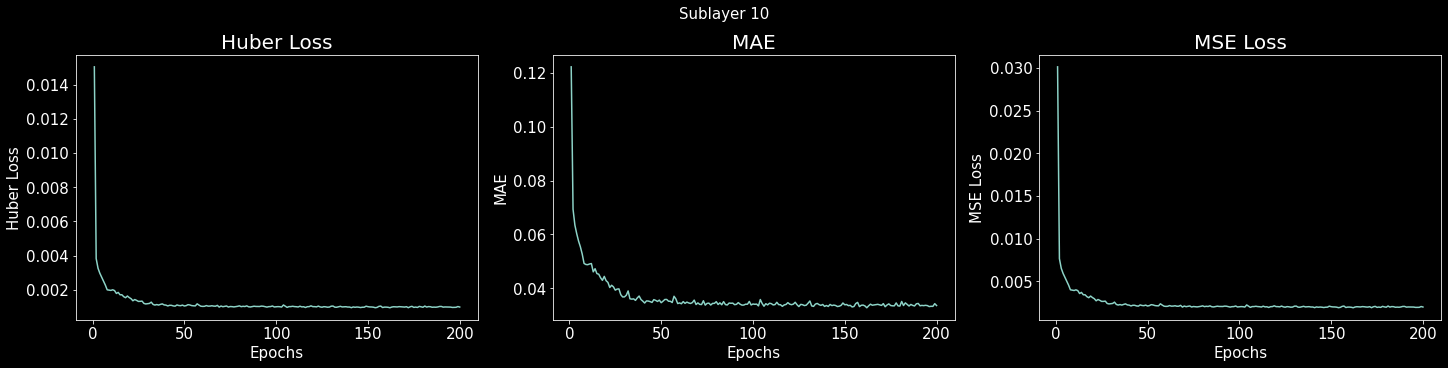

In [13]:
for i, j in tqdm(enumerate(models_hists)):
    plot_metrics(j.history, epochs, title = 'Sublayer {}'.format(i + 1))

In [14]:
forecasts = []
val_data_list = []
for i, model in tqdm(enumerate(models_list)):
    input_data = decomposed.iloc[:, i:i+1]
    forecast = model_forecast(input_data, model, window_size, split_point, scalers[i])
    val_data = decomposed.iloc[split_point:, i:i+1].values
    forecasts.append(forecast)
    val_data_list.append(val_data)

10it [00:08,  1.16it/s]


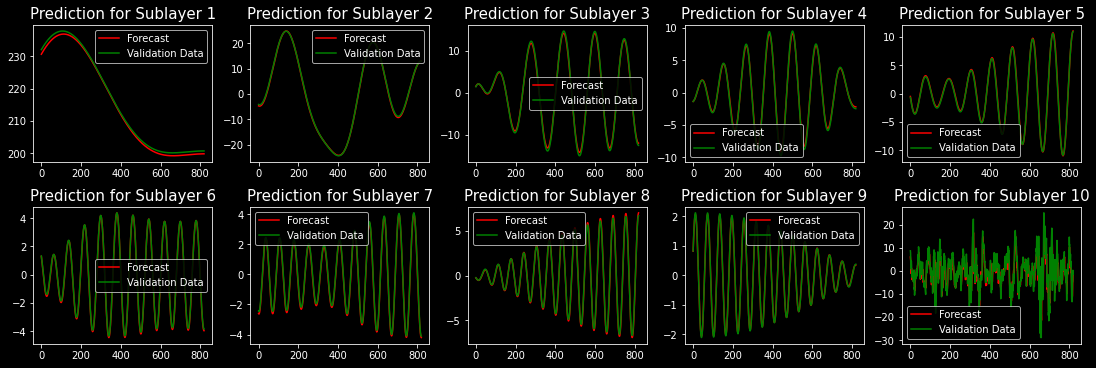

In [15]:
plt.style.use('dark_background')
fig, ax = plt.subplots(2, 5, constrained_layout = True, figsize = (15, 5))
for i in range(2):
    for j in range(5):
        # print(forecasts[j + 5*i])
        ax[i][j].plot(forecasts[j + 5*i], 'r') 
        ax[i][j].plot(val_data_list[j + 5*i], 'g')
        ax[i][j].set_title('Prediction for Sublayer {}'.format(j + 5*i + 1), fontsize = 15)
        # plt.plot(forecasts[i], 'r')
        ax[i][j].legend(['Forecast', 'Validation Data'])
plt.show()

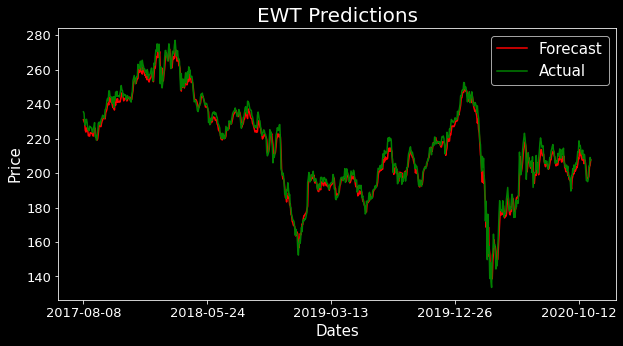

In [16]:
date_ticks = []
x_ticks_pos = []
for i, j in enumerate(dates[split_point:]):
  if not i%200:
    date_ticks.append(j)
    x_ticks_pos.append(i)

plt.figure(figsize = (10, 5))
overall_forecast = sum(forecasts)
overall_val = sum(val_data_list)
plt.plot(overall_forecast, 'r')
plt.plot(overall_val, 'g')
plt.xticks(x_ticks_pos, date_ticks)
plt.tick_params(axis='both', labelsize = 13)
plt.xlabel('Dates', fontsize = 15)
plt.ylabel('Price', fontsize = 15)
plt.title('EWT Predictions', fontsize = 20)
plt.legend(['Forecast', 'Actual'], fontsize = 15)

In [17]:
print('Error by EWT decomposition: ', mse(overall_val, overall_forecast))

Error by EWT decomposition:  18.1280310838566
